# Look at the damn birds 🐦

In [83]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx
import spaghetti
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.9/site-packages/esda/getisord.py:636: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if __name__ is "__main__":
/opt/conda/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [4]:
birds = pd.read_csv('../data/birds.csv', delimiter=';', decimal=',', encoding='Windows-1252')

In [5]:
birds.head()

,Dato,Turtidfra,Turtidtil,Loknr,Loknavn,Artnr,Artnavn,Latin,Sortering,Antal,...,Hemmelig,Kvalitet,Turid,Obsid,Kommune,lok_laengdegrad,lok_breddegrad,obs_laengdegrad,obs_breddegrad,radius
0,2023-12-31,NaN,NaN,101055,Kalveboderne og Kalvebodløbet,70,Lille Lappedykker,Tachybaptus ruficollis,1370,150,...,0,1,5201267,33425067,København,12.518198,55.627968,NaN,NaN,NaN
1,2023-12-31,15:31,15:36,101029,Emdrup,90,Toppet Lappedykker,Podiceps cristatus,1390,1,...,0,1,5198978,33411057,København,12.542466,55.721523,NaN,NaN,NaN
2,2023-12-31,12:08,NaN,101112,Sortedamssøen. S-del,90,Toppet Lappedykker,Podiceps cristatus,1390,3,...,0,1,5198698,33409574,København,12.566923,55.689097,NaN,NaN,NaN
3,2023-12-31,11:32,NaN,101114,Skt. Jørgens Sø. N-del,90,Toppet Lappedykker,Podiceps cristatus,1390,3,...,0,1,5198650,33409237,København,12.558525,55.679531,NaN,NaN,NaN
4,2023-12-31,13:05,13:55,101211,Damhussøen,90,Toppet Lappedykker,Podiceps cristatus,1390,8,...,0,1,5199009,33411286,København,12.477069,55.675953,NaN,NaN,NaN


In [12]:
gdf = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(birds.obs_laengdegrad, birds.obs_breddegrad), crs="EPSG:4326"
)

In [13]:
# remove observations without exact coordinates
gdf = gdf[~gdf.geometry.is_empty]

## Visualizing bird sightings
For point pattern plots, we create `gdf_exploded` with duplicate entries based on the number of observations on the location.

In [14]:
gdf_exploded = gdf.loc[gdf.index.repeat(gdf.Antal)]

#### Point pattern plot
Plot each individual observation on the map

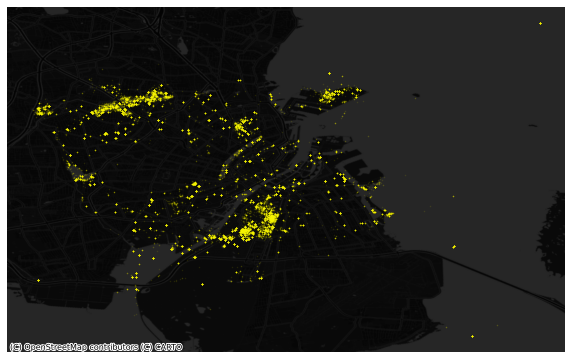

In [15]:
f, ax = plt.subplots(figsize=(10,10))
gdf_exploded.plot(
    markersize=0.25,
    c="xkcd:bright yellow",
    alpha=0.1,
    ax=ax)
cx.add_basemap(source=cx.providers.CartoDB.DarkMatterNoLabels, crs=gdf.crs, ax=ax)
ax.set_axis_off()

#### Point pattern with marginal distribution

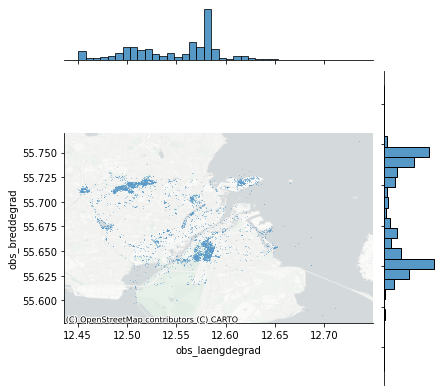

In [26]:
joint_axes = sns.jointplot(
    x='obs_laengdegrad', y='obs_breddegrad', data=gdf, s=0.5
)
cx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.PositronNoLabels
);

#### Point pattern of N most common bird types

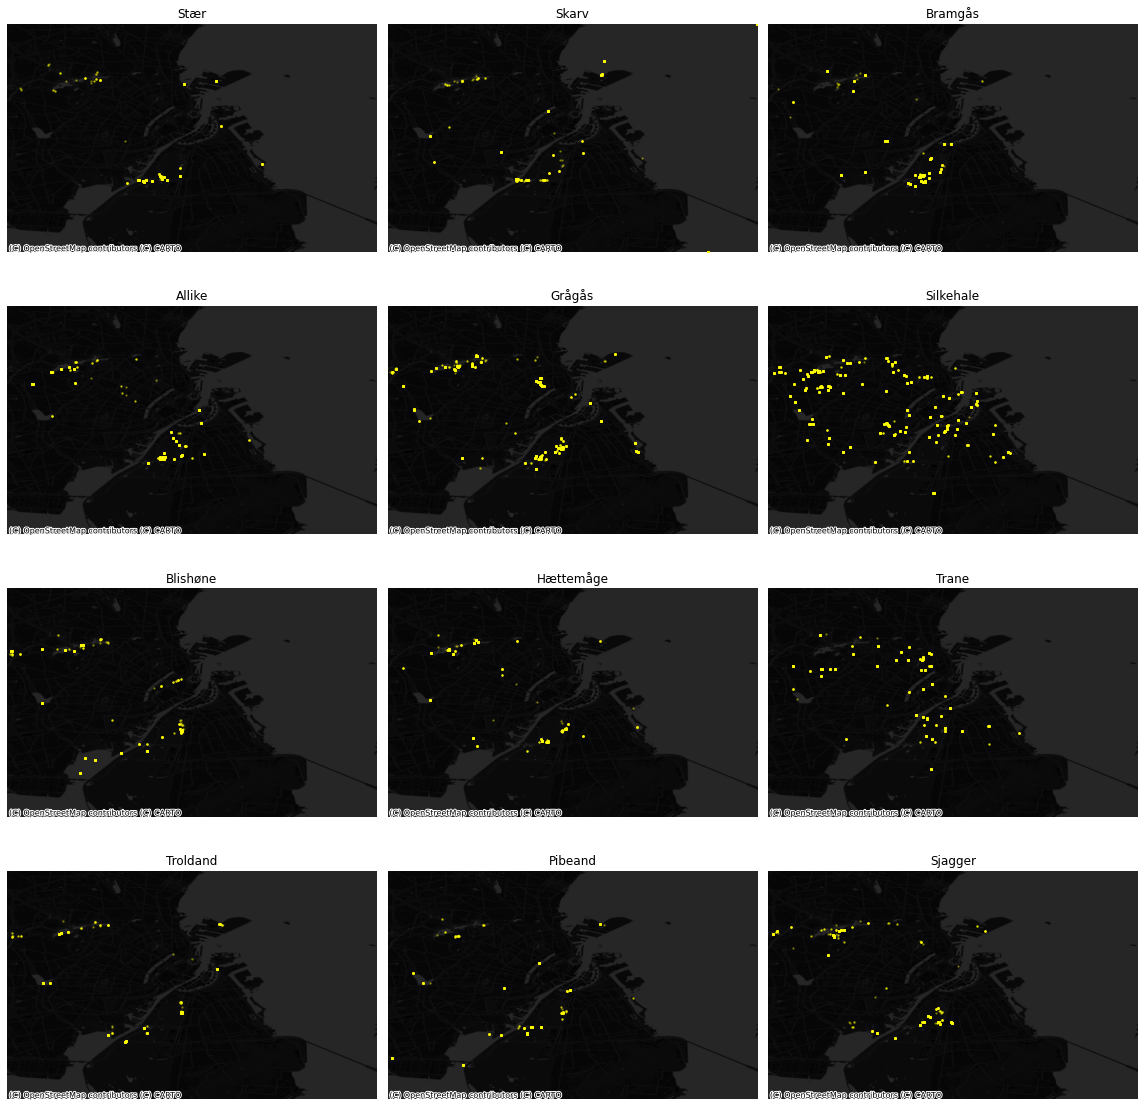

In [63]:
N = 12
bird_types = gdf_exploded.Artnavn.value_counts().index.to_list()

f, axes = plt.subplots(int(N/3), 3, figsize=(16,16))
axes = axes.flatten()

minx, miny, maxx, maxy = gdf.geometry.total_bounds

for i in range(N):
    ax = axes[i]
    bird_type = bird_types[i]
    
    type_df = gdf_exploded[gdf_exploded.Artnavn == bird_type]
    ax.scatter(type_df.geometry.x, type_df.geometry.y, s=2, c="xkcd:bright yellow", alpha=0.3)
    
    ax.set_title(bird_type)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_axis_off()
    
    cx.add_basemap(ax=ax, crs=type_df.crs, source=cx.providers.CartoDB.DarkMatterNoLabels)
    
plt.tight_layout()

#### Hexbin

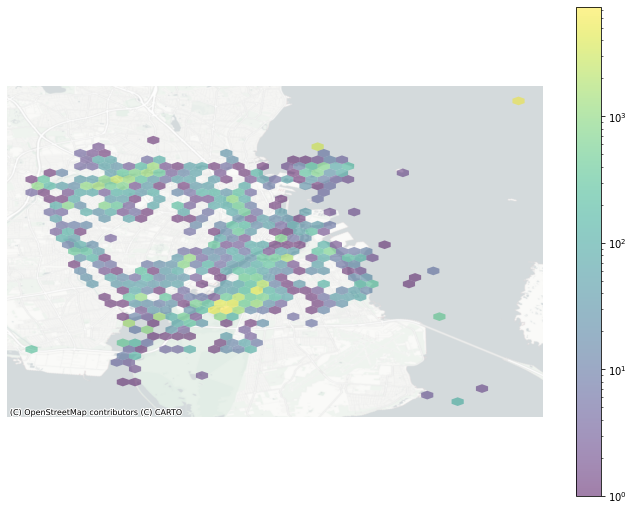

In [8]:
f, ax = plt.subplots(1, figsize=(12, 9))
hb = ax.hexbin(
    gdf_exploded.geometry.x, 
    gdf_exploded.geometry.y, 
    gridsize=40, 
    alpha=0.5,
    edgecolor="none",
    bins='log',
    mincnt=1
)

plt.colorbar(hb)

cx.add_basemap(source=cx.providers.CartoDB.PositronNoLabels, crs=gdf.crs, ax=ax)
ax.set_axis_off()

#### KDE plot

Text(0.5, 1.0, 'KDE of photos in Tokyo')

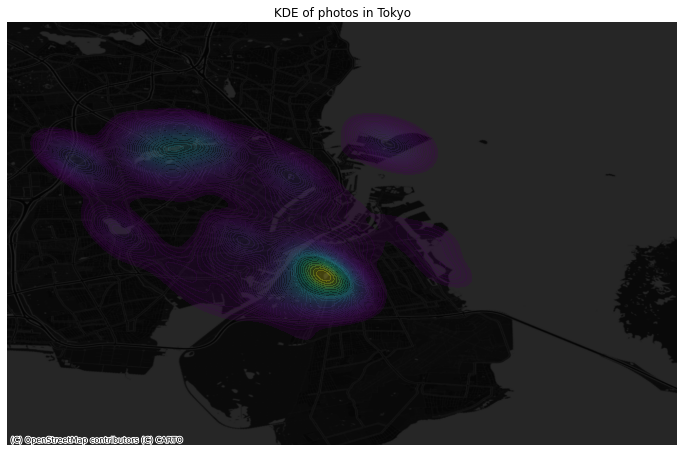

In [39]:
f, ax = plt.subplots(1, figsize=(12, 12))

sns.kdeplot(
    data=gdf,
    x='obs_laengdegrad', 
    y='obs_breddegrad', 
    n_levels=50, 
    shade=True,
    alpha=0.25,
    cmap="viridis"
)

ax.set_axis_off()
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
ax.set_title("KDE of photos in Tokyo")

## Birds in relation to bike paths
We want to use bird observations as an edge feature on the bicycle street network.
### Load data

In [43]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


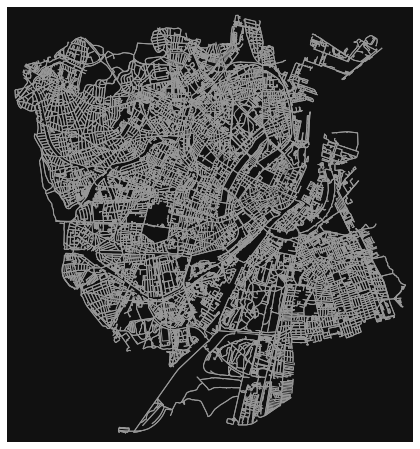

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [50]:
ox.plot_graph(G, node_size=0)

In [82]:
ox.io.save_graph_shapefile(G, "copenhagen")

/opt/conda/lib/python3.9/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [85]:
# be careful, this takes forever
ntw = spaghetti.Network(in_data="copenhagen/edges.shp")

In [87]:
ntw.savenetwork('copenhagen_ntw')

In [99]:
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

### Pointwise snap each observation to nearest road

In [121]:
sample = gdf.sample(1000)

In [122]:
ntw.snapobservations(sample, 'birds', attribute=True)
ntw.pointpatterns

{'birds': <spaghetti.network.PointPattern at 0x7b54c6c06e80>}

In [123]:
sample_snapped = spaghetti.element_as_gdf(ntw, pp_name='birds', snapped=True)

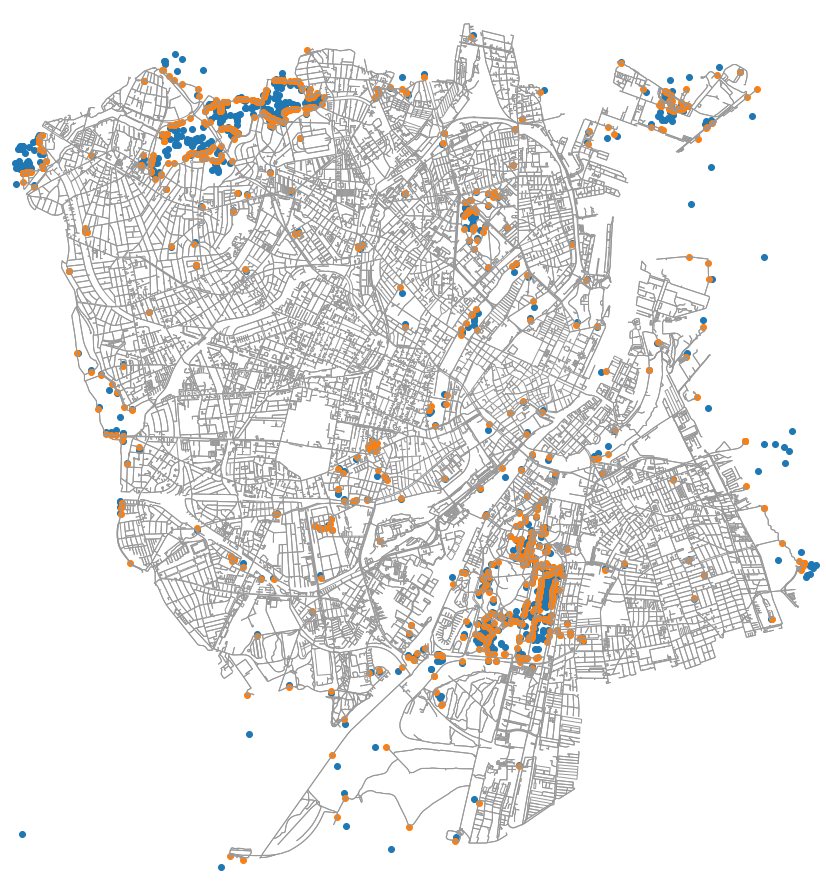

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

In [134]:
f, ax = plt.subplots(figsize=(16,16))

sample.plot(ax=ax)
sample_snapped.plot(ax=ax)

ox.plot_graph(G, node_size=0, bgcolor="w", ax=ax)